In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [3]:
%pip install tf-nightly-2.0-preview


ERROR: Could not find a version that satisfies the requirement tf-nightly-2.0-preview (from versions: none)
ERROR: No matching distribution found for tf-nightly-2.0-preview
Note: you may need to restart the kernel to use updated packages.


In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.8.0


In [5]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [6]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [7]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-04-20 18:27:14.483490: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-04-20 18:27:14.483849: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, None, 1)           0         
                                                                 
 bidirectional (Bidirectiona  (None, None, 64)         8704      
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               24832     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
 lambda_1 (Lambda)           (None, 1)                 0         
                                                                 
Total params: 33,601
Trainable params: 33,601
Non-traina

In [12]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 3))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset, epochs=20, callbacks=[lr_schedule])

Epoch 1/20


2022-04-20 18:28:52.434235: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-20 18:28:52.827451: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-20 18:28:52.838152: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-20 18:28:52.900563: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-20 18:28:52.911946: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-20 18:28:53.010268: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-20 18:28:53.026563: I tensorflow/core/grappler/optimizers/cust

      2/Unknown - 3s 66ms/step - loss: 6.6580 - mae: 7.1303

2022-04-20 18:28:53.129833: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-20 18:28:53.146220: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


31/31 [==============================] - 4s 40ms/step - loss: 8.0853 - mae: 8.5692 - lr: 1.0000e-08
Epoch 2/20
31/31 [==============================] - 1s 32ms/step - loss: 8.0480 - mae: 8.5295 - lr: 2.1544e-08
Epoch 3/20
31/31 [==============================] - 1s 32ms/step - loss: 8.0120 - mae: 8.4921 - lr: 4.6416e-08
Epoch 4/20
31/31 [==============================] - 1s 31ms/step - loss: 7.9730 - mae: 8.4551 - lr: 1.0000e-07
Epoch 5/20
31/31 [==============================] - 1s 32ms/step - loss: 7.8656 - mae: 8.3477 - lr: 2.1544e-07
Epoch 6/20
31/31 [==============================] - 1s 33ms/step - loss: 7.7685 - mae: 8.2474 - lr: 4.6416e-07
Epoch 7/20
31/31 [==============================] - 1s 33ms/step - loss: 7.7516 - mae: 8.2343 - lr: 1.0000e-06
Epoch 8/20
31/31 [==============================] - 1s 32ms/step - loss: 7.9595 - mae: 8.4423 - lr: 2.1544e-06
Epoch 9/20
31/31 [==============================] - 1s 34ms/step - loss: 7.5188 - mae: 8.0030 - lr: 4.6416e-06
Epoch 10/20


(1e-08, 0.0001, 0.0, 30.0)

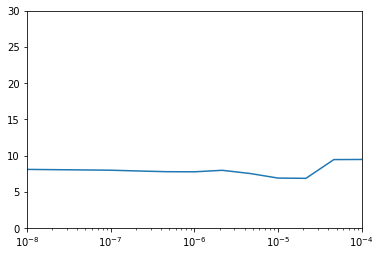

In [13]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [15]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])


model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9),metrics=["mae"])
history = model.fit(dataset,epochs=20,verbose=2)

Epoch 1/20


2022-04-20 18:29:47.802468: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-20 18:29:48.189071: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-20 18:29:48.200709: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-20 18:29:48.263504: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-20 18:29:48.274816: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-20 18:29:48.372169: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-20 18:29:48.388392: I tensorflow/core/grappler/optimizers/cust

31/31 - 4s - loss: 1921.3555 - mae: 30.2729 - 4s/epoch - 126ms/step
Epoch 2/20
31/31 - 1s - loss: 241.4383 - mae: 12.3939 - 1s/epoch - 33ms/step
Epoch 3/20
31/31 - 1s - loss: 129.7296 - mae: 8.6112 - 951ms/epoch - 31ms/step
Epoch 4/20
31/31 - 1s - loss: 107.9687 - mae: 7.9155 - 957ms/epoch - 31ms/step
Epoch 5/20
31/31 - 1s - loss: 85.9849 - mae: 7.1394 - 956ms/epoch - 31ms/step
Epoch 6/20
31/31 - 1s - loss: 135.8009 - mae: 9.2433 - 964ms/epoch - 31ms/step
Epoch 7/20
31/31 - 1s - loss: 128.7335 - mae: 9.0086 - 958ms/epoch - 31ms/step
Epoch 8/20
31/31 - 1s - loss: 76.3132 - mae: 6.7988 - 948ms/epoch - 31ms/step
Epoch 9/20
31/31 - 1s - loss: 80.2716 - mae: 6.9311 - 944ms/epoch - 30ms/step
Epoch 10/20
31/31 - 1s - loss: 87.5586 - mae: 7.4030 - 962ms/epoch - 31ms/step
Epoch 11/20
31/31 - 1s - loss: 85.2743 - mae: 7.1536 - 981ms/epoch - 32ms/step
Epoch 12/20
31/31 - 1s - loss: 113.5176 - mae: 8.4647 - 965ms/epoch - 31ms/step
Epoch 13/20
31/31 - 1s - loss: 115.5459 - mae: 8.6355 - 964ms/epoch

2022-04-20 18:30:10.862176: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-20 18:30:10.990898: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-20 18:30:11.003096: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-20 18:30:11.954342: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-20 18:30:11.962430: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


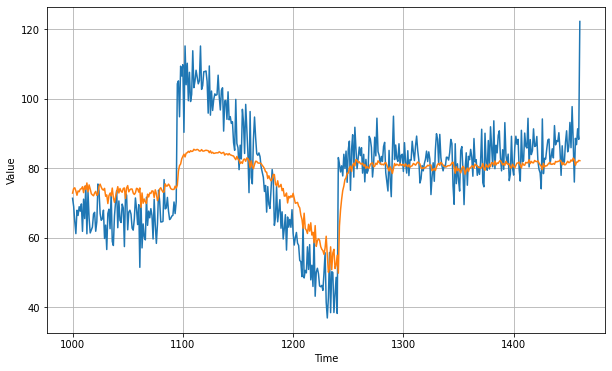

In [16]:
forecast = []
results = []
for time in range(len(series) - window_size):
      print(time, len(series) - window_size)
      forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [17]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

7.678926

<Figure size 432x288 with 0 Axes>

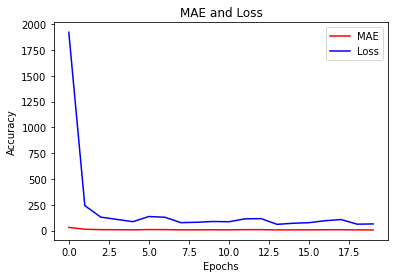

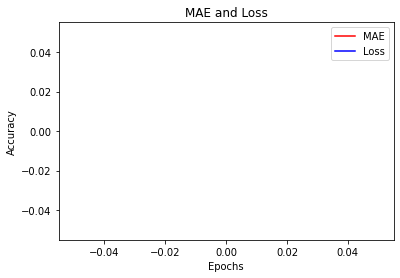

<Figure size 432x288 with 0 Axes>

In [18]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

In [ ]:
tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])


model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model.fit(dataset,epochs=100, verbose=0)

In [19]:
tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])


model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model.fit(dataset,epochs=30, verbose=2)

Epoch 1/30


/Users/viktorcikojevic/miniforge3/envs/env_tf/lib/python3.9/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)
2022-04-20 18:31:46.972316: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-20 18:31:47.548919: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-20 18:31:47.560384: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-20 18:31:47.631283: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-20 18:31:47.642625: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU 

31/31 - 7s - loss: 582.6314 - 7s/epoch - 218ms/step
Epoch 2/30
31/31 - 1s - loss: 153.1512 - 1s/epoch - 47ms/step
Epoch 3/30
31/31 - 1s - loss: 114.1580 - 1s/epoch - 45ms/step
Epoch 4/30
31/31 - 1s - loss: 100.3402 - 1s/epoch - 46ms/step
Epoch 5/30
31/31 - 1s - loss: 93.5909 - 1s/epoch - 46ms/step
Epoch 6/30
31/31 - 1s - loss: 84.8885 - 1s/epoch - 45ms/step
Epoch 7/30
31/31 - 1s - loss: 78.3585 - 1s/epoch - 47ms/step
Epoch 8/30
31/31 - 1s - loss: 68.6347 - 1s/epoch - 47ms/step
Epoch 9/30
31/31 - 1s - loss: 64.2155 - 1s/epoch - 47ms/step
Epoch 10/30
31/31 - 1s - loss: 62.1250 - 1s/epoch - 47ms/step
Epoch 11/30
31/31 - 1s - loss: 61.3214 - 1s/epoch - 45ms/step
Epoch 12/30
31/31 - 1s - loss: 59.7542 - 1s/epoch - 45ms/step
Epoch 13/30
31/31 - 1s - loss: 60.6463 - 1s/epoch - 46ms/step
Epoch 14/30
31/31 - 1s - loss: 57.4911 - 1s/epoch - 46ms/step
Epoch 15/30
31/31 - 1s - loss: 56.5601 - 1s/epoch - 47ms/step
Epoch 16/30
31/31 - 1s - loss: 57.2610 - 1s/epoch - 46ms/step
Epoch 17/30
31/31 - 1s 